
# Sentiment Analysis on Customer Reviews
This project performs sentiment analysis on consumer product reviews to determine whether each review expresses a positive or negative sentiment. 
The analysis leverages different text classification models, including Naive Bayes, XGBoost, and HuggingFace Transformers. By comparing these approaches, we aim to identify the model that provides the most accurate predictions on unseen review data.

**Workflow Overview**:
1. Data Cleaning and Preprocessing
2. Exploratory Data Analysis (EDA)
3. Text Vectorization
4. Model Training and Evaluation


<a id='imp'></a>
# Importing packages and loading data

In [1]:
# required libraries
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

import spacy
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.naive_bayes import MultinomialNB

from xgboost import XGBClassifier

from transformers import pipeline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load dataset 
df = pd.read_csv(r"C:/zshahpouri/data/1429_1/1429_1.csv")
df.head(2)

,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman


<a id='eda'></a>
# Exploratory Data Analysis (EDA)


Since we are interested in sentiment analysis, we will only use `reviews.text` and `reviews.rating`

### Sample the Data: 
we use a random subset of 10000 rows for better performance, reduce memory usage.
fixed seed makes our choices reproducible.

In [ ]:

data = df[["reviews.text","reviews.rating"]].sample(10000,random_state=23)
data.head()

,reviews.text,reviews.rating
21536,Bought as a Mother's Day Gift. This is great f...,4.0
20669,I can hold this next to my Kindle Paperwhite a...,5.0
30656,Love this device and went on to buy 2 as gifts...,5.0
25297,"With some technical savvy, you can quickly hav...",5.0
9016,bought for grandkids they love them. wise choi...,5.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 21536 to 29020
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviews.text    10000 non-null  object 
 1   reviews.rating  9993 non-null   float64
dtypes: float64(1), object(1)
memory usage: 234.4+ KB


In [5]:
# drop missing values
data.dropna(inplace=True)
data.isnull().sum()

reviews.text      0
reviews.rating    0
dtype: int64

In [6]:
# descriptive statistics
data.describe()

,reviews.rating
count,9993.000000
mean,4.591414
std,0.725462
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [7]:
# distribution of rating
data['reviews.rating'].value_counts().sort_index(ascending=False)

reviews.rating
5.0    6891
4.0    2455
3.0     420
2.0     120
1.0     107
Name: count, dtype: int64

In [8]:
# Drop NaNs if they exist
data = data.dropna(subset=['reviews.rating'])

# Convert to integers
data['reviews.rating'] = data['reviews.rating'].astype(int)


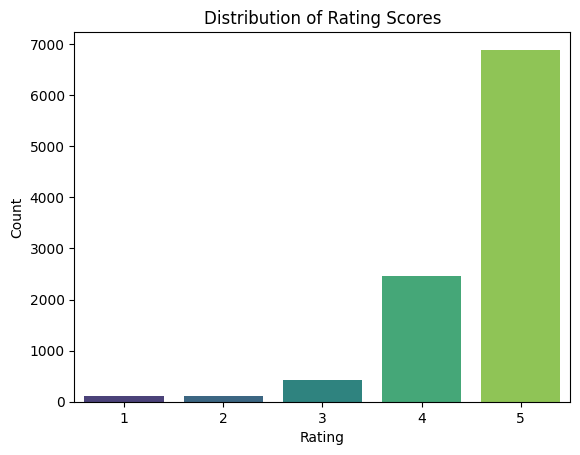

In [9]:
sns.countplot(data=data, x='reviews.rating', palette='viridis')
plt.title('Distribution of Rating Scores')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


In [10]:
# map ratings 1, 2, 3 to 0 (NEGATIVE) and 4, 5 to 1 (POSITIVE) 
sentiment_score = {1: 0,
                   2: 0,
                   3: 0,
                   4: 1,
                   5: 1}

sentiment = {0: 'NEGATIVE',
             1: 'POSITIVE'}


# mapping
data['sentiment_score'] = data['reviews.rating'].map(sentiment_score)
data['sentiment'] = data['sentiment_score'].map(sentiment)

data.head()

,reviews.text,reviews.rating,sentiment_score,sentiment
21536,Bought as a Mother's Day Gift. This is great f...,4,1,POSITIVE
20669,I can hold this next to my Kindle Paperwhite a...,5,1,POSITIVE
30656,Love this device and went on to buy 2 as gifts...,5,1,POSITIVE
25297,"With some technical savvy, you can quickly hav...",5,1,POSITIVE
9016,bought for grandkids they love them. wise choi...,5,1,POSITIVE


In [11]:
data['sentiment_score'].value_counts()

sentiment_score
1    9346
0     647
Name: count, dtype: int64

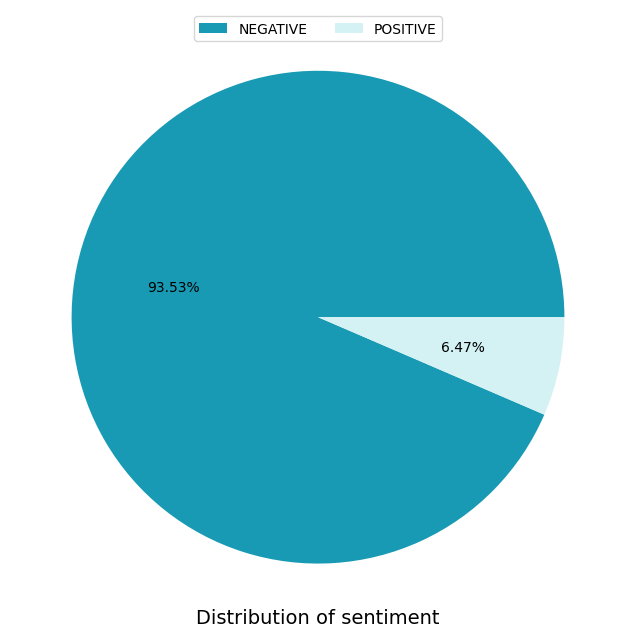

In [12]:
# distribution of sentiment
plt.figure(figsize = (8, 8))

labels = ['NEGATIVE','POSITIVE']
colors = ['#189AB4', '#D4F1F4']
plt.pie(data['sentiment'].value_counts(), autopct='%0.2f%%',colors=colors)

plt.title('Distribution of sentiment', size=14, y=-0.01)
plt.legend(labels, ncol=2, loc=9)
plt.show()

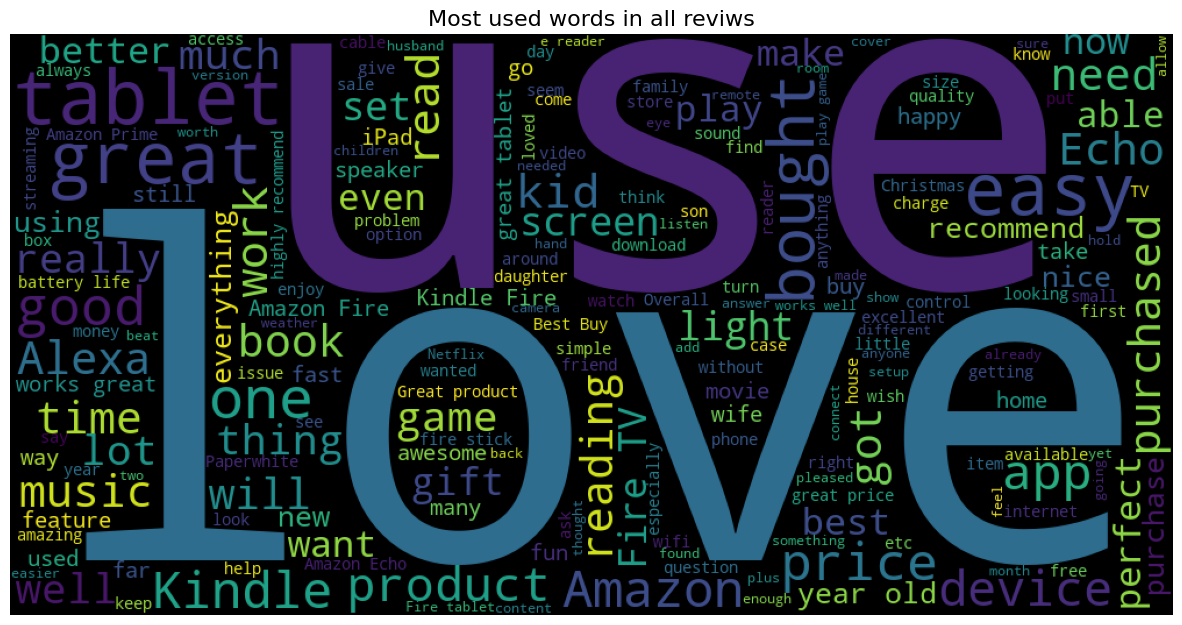

In [13]:
all_words = pd.Series(' '.join(data['reviews.text']).split())
# plot word cloud
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(all_words))

plt.figure(figsize=(15,8))

plt.imshow(wordcloud)
plt.title("Most used words in all reviws", size=16)

plt.axis("off")
plt.show()

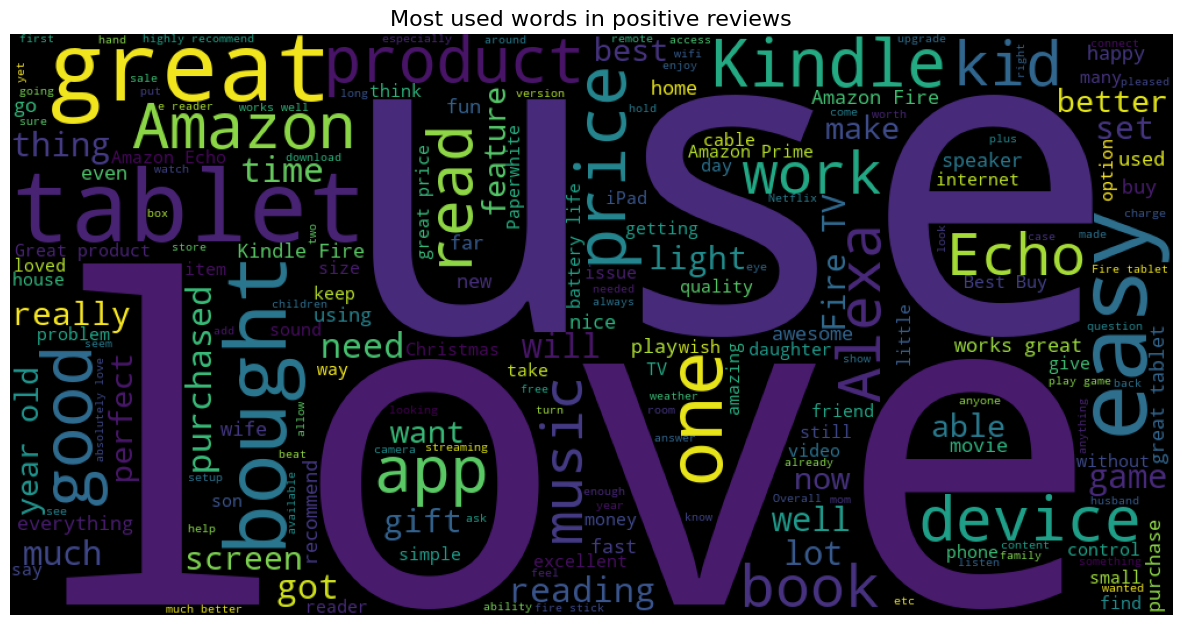

In [14]:
positiveWords = pd.Series(' '.join(data[data['sentiment']=='POSITIVE']['reviews.text']).split())

# plot word cloud
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(positiveWords))

plt.figure(figsize=(15,8))

plt.imshow(wordcloud)
plt.title("Most used words in positive reviews", size=16)

plt.axis("off")
plt.show()

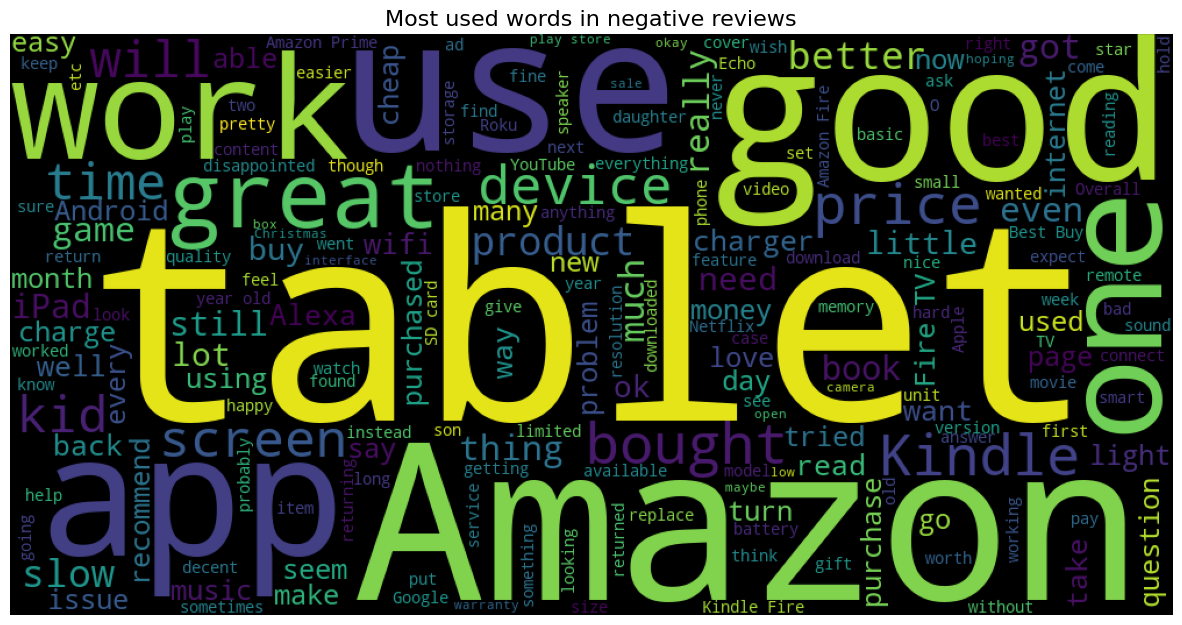

In [15]:
negativeWords = pd.Series(' '.join(data[data['sentiment']=='NEGATIVE']['reviews.text']).split())
# plot word cloud
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(negativeWords))

plt.figure(figsize=(15,8))

plt.imshow(wordcloud)
plt.title("Most used words in negative reviews", size=16)

plt.axis("off")
plt.show()

-------------